## motion

### set up

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### data 읽어오기

In [2]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [3]:
print('모션의 종류별 개수_Train')
print(train.groupby('500').size().reset_index(name='count'))

print('모션의 종류별 개수_Validation')
print(val.groupby('500').size().reset_index(name='count'))


모션의 종류별 개수_Train
   500  count
0    0    480
1    1    480
2    2    480
3    3    480
4    4    480
5    5    480
6    6    480
7    7    480
모션의 종류별 개수_Validation
   500  count
0    0     37
1    1     45
2    2     42
3    3     43
4    4     56
5    5     50
6    6     48
7    7     49


### 데이터 전처리(훈련데이터, 검증데이터 데이터 & 라벨(정답)분류)

In [4]:
import copy

label_cols = ['500']
label_df = pd.DataFrame(train,columns=label_cols)
label_df2 = pd.DataFrame(val,columns=label_cols)

traindf = copy.deepcopy(train)
traindf = traindf.drop(columns='500')
feature_df = pd.DataFrame(traindf,columns=traindf.columns)


valdf = copy.deepcopy(val)
valdf = valdf.drop(columns='500')
feature_df2 = pd.DataFrame(valdf,columns=valdf.columns)

### 시계열 데이터 형태로 변경

In [5]:
def make_sequence_dataset(feature,label):
    
    feature_list = []
    label_list = []
    
    for i in range(len(feature)):
        
        feature_list.append(feature[i])
        label_list.append(label[i])
        
    return np.array(feature_list),np.array(label_list)

In [6]:
label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

label_np2 = label_df2.to_numpy()
feature_np2 = feature_df2.to_numpy()


X_data,Y_data = make_sequence_dataset(feature_np,label_np)

print(X_data.shape,Y_data.shape)

(3840, 500) (3840, 1)


### 훈련데이터를 테스트 데이터로 분류

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size=0.05,random_state=0,stratify=Y_data)

In [8]:
X_val,Y_val = make_sequence_dataset(feature_np2,label_np2)

In [9]:
print(X_train.shape,X_test.shape,X_val.shape)
X_train = X_train.reshape(3648,500,1)
X_test = X_test.reshape(192,500,1)
X_val = X_val.reshape(370,500,1)

(3648, 500) (192, 500) (370, 500)


In [10]:
print(Y_train.shape,Y_test.shape,Y_val.shape)
Y_train = Y_train.reshape(3648,)
Y_test = Y_test.reshape(192,)
Y_val = Y_val.reshape(370,)

(3648, 1) (192, 1) (370, 1)


In [11]:
print(Y_train.shape,Y_test.shape,Y_val.shape)

print(X_train.shape,X_test.shape,X_val.shape)

(3648,) (192,) (370,)
(3648, 500, 1) (192, 500, 1) (370, 500, 1)


In [12]:
print(
"Using %d samples for training and %d samples for test and %d for validation"
% (len(X_train),len(X_test),len(X_val))
)

Using 3648 samples for training and 192 samples for test and 370 for validation


## model 설계

In [29]:
batch_size = 57
input_dim = 1

units = 64
output_size = 8  # labels are from 0 to 7
regularization_strength = 0.01
#가중치 감쇠 적용(L2 norm), 마지막 출력층 활성화함수 softmax 적용, dropout layer로 변경, 조기멈춤 등 콜백함수 추가, 학습률 조정

model = Sequential()
model.add(layers.LSTM(units,
                      kernel_regularizer=regularizers.l2(regularization_strength),
                      input_shape=(None, input_dim)))
model.add(Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(output_size,kernel_regularizer=regularizers.l2(regularization_strength),activation='softmax'))

In [30]:
es = EarlyStopping(monitor='val_acc',patience=350,verbose=1,mode='max',restore_best_weights=True,baseline=0.96)
mc = ModelCheckpoint("./check.h5", save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_acc',factor=0.9, patience=5,verbose=1,mode='max',min_lr=0.0005)
csvlogger = CSVLogger("./epoch.log")
opt = keras.optimizers.Adam(learning_rate=0.005)
# 모델 확정 조작 파라미터 = 학습률, lstm 차원
model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=["acc"]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 17,672
Trainable params: 17,544
Non-trainable params: 128
_________________________________________________________________


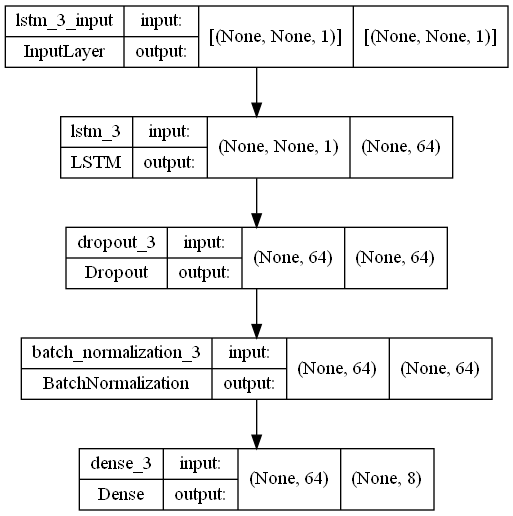

In [31]:
keras.utils.plot_model(model, "model_shape_info.png", show_shapes=True)

### 학습

In [32]:
hist = model.fit(
    X_train, Y_train, validation_data=(X_val, Y_val), batch_size=batch_size, epochs=350,callbacks=[es,mc,rlr,csvlogger]
)

Epoch 1/350
64/64 [==============================] - 21s 295ms/step - loss: 1.8600 - acc: 0.3048 - val_loss: 2.0692 - val_acc: 0.1568 - lr: 0.0050
Epoch 2/350
64/64 [==============================] - 17s 265ms/step - loss: 1.7096 - acc: 0.3353 - val_loss: 2.0471 - val_acc: 0.1703 - lr: 0.0050
Epoch 3/350
64/64 [==============================] - 18s 280ms/step - loss: 1.6424 - acc: 0.3533 - val_loss: 1.9580 - val_acc: 0.2108 - lr: 0.0050
Epoch 4/350
64/64 [==============================] - 19s 304ms/step - loss: 1.7086 - acc: 0.3237 - val_loss: 1.8594 - val_acc: 0.2919 - lr: 0.0050
Epoch 5/350
64/64 [==============================] - 18s 277ms/step - loss: 1.6299 - acc: 0.3446 - val_loss: 1.8355 - val_acc: 0.3108 - lr: 0.0050
Epoch 6/350
64/64 [==============================] - 19s 290ms/step - loss: 1.6138 - acc: 0.3635 - val_loss: 1.7576 - val_acc: 0.3243 - lr: 0.0050
Epoch 7/350
64/64 [==============================] - 18s 282ms/step - loss: 1.5693 - acc: 0.3961 - val_loss: 1.8086 - 

Epoch 100/350
64/64 [==============================] - 17s 262ms/step - loss: 0.4418 - acc: 0.8555 - val_loss: 0.4714 - val_acc: 0.8676 - lr: 0.0014
Epoch 101/350
64/64 [==============================] - 17s 261ms/step - loss: 0.5145 - acc: 0.8320 - val_loss: 0.5016 - val_acc: 0.8351 - lr: 0.0014
Epoch 102/350
64/64 [==============================] - 17s 265ms/step - loss: 0.5010 - acc: 0.8350 - val_loss: 0.5597 - val_acc: 0.8216 - lr: 0.0014
Epoch 103/350
64/64 [==============================] - 17s 269ms/step - loss: 0.4523 - acc: 0.8501 - val_loss: 0.4341 - val_acc: 0.8757 - lr: 0.0014
Epoch 104/350
64/64 [==============================] - 17s 261ms/step - loss: 0.4250 - acc: 0.8627 - val_loss: 0.4729 - val_acc: 0.8514 - lr: 0.0014
Epoch 105/350
64/64 [==============================] - 17s 261ms/step - loss: 0.4282 - acc: 0.8638 - val_loss: 0.6319 - val_acc: 0.8027 - lr: 0.0014
Epoch 106/350
64/64 [==============================] - 17s 260ms/step - loss: 0.4867 - acc: 0.8369 - val_l

64/64 [==============================] - 17s 270ms/step - loss: 0.3609 - acc: 0.8821 - val_loss: 0.4038 - val_acc: 0.8865 - lr: 6.0788e-04
Epoch 147/350
64/64 [==============================] - 19s 291ms/step - loss: 0.3499 - acc: 0.8904 - val_loss: 0.4184 - val_acc: 0.8811 - lr: 6.0788e-04
Epoch 148/350
64/64 [==============================] - 19s 303ms/step - loss: 0.3466 - acc: 0.8931 - val_loss: 0.4111 - val_acc: 0.8811 - lr: 6.0788e-04
Epoch 149/350
64/64 [==============================] - 18s 277ms/step - loss: 0.3536 - acc: 0.8912 - val_loss: 0.3859 - val_acc: 0.8919 - lr: 6.0788e-04
Epoch 150/350
64/64 [==============================] - 17s 262ms/step - loss: 0.3454 - acc: 0.8893 - val_loss: 0.4177 - val_acc: 0.8622 - lr: 6.0788e-04
Epoch 151/350
64/64 [==============================] - 17s 261ms/step - loss: 0.3528 - acc: 0.8868 - val_loss: 0.4033 - val_acc: 0.8865 - lr: 6.0788e-04
Epoch 152/350
64/64 [==============================] - 17s 264ms/step - loss: 0.3721 - acc: 0.87

Epoch 198/350
64/64 [==============================] - 17s 266ms/step - loss: 0.2964 - acc: 0.9046 - val_loss: 0.3517 - val_acc: 0.8919 - lr: 5.0000e-04
Epoch 199/350
64/64 [==============================] - 17s 267ms/step - loss: 0.2863 - acc: 0.9115 - val_loss: 0.3286 - val_acc: 0.8946 - lr: 5.0000e-04
Epoch 200/350
64/64 [==============================] - 17s 269ms/step - loss: 0.2903 - acc: 0.9062 - val_loss: 0.3260 - val_acc: 0.9000 - lr: 5.0000e-04
Epoch 201/350
64/64 [==============================] - 18s 277ms/step - loss: 0.2759 - acc: 0.9087 - val_loss: 0.3640 - val_acc: 0.8919 - lr: 5.0000e-04
Epoch 202/350
64/64 [==============================] - 17s 269ms/step - loss: 0.2684 - acc: 0.9153 - val_loss: 0.3273 - val_acc: 0.9027 - lr: 5.0000e-04
Epoch 203/350
64/64 [==============================] - 17s 267ms/step - loss: 0.2664 - acc: 0.9137 - val_loss: 0.3604 - val_acc: 0.9027 - lr: 5.0000e-04
Epoch 204/350
64/64 [==============================] - 17s 266ms/step - loss: 0.26

Epoch 305/350
64/64 [==============================] - 21s 335ms/step - loss: 0.3997 - acc: 0.8676 - val_loss: 0.4700 - val_acc: 0.8405 - lr: 5.0000e-04
Epoch 306/350
64/64 [==============================] - 21s 324ms/step - loss: 0.3766 - acc: 0.8766 - val_loss: 0.4234 - val_acc: 0.8486 - lr: 5.0000e-04
Epoch 307/350
64/64 [==============================] - 19s 302ms/step - loss: 0.3936 - acc: 0.8687 - val_loss: 0.4550 - val_acc: 0.8378 - lr: 5.0000e-04
Epoch 308/350
64/64 [==============================] - 19s 294ms/step - loss: 0.3586 - acc: 0.8794 - val_loss: 0.4200 - val_acc: 0.8595 - lr: 5.0000e-04
Epoch 309/350
64/64 [==============================] - 19s 300ms/step - loss: 0.3523 - acc: 0.8871 - val_loss: 0.4572 - val_acc: 0.8676 - lr: 5.0000e-04
Epoch 310/350
64/64 [==============================] - 19s 302ms/step - loss: 0.3789 - acc: 0.8717 - val_loss: 0.4678 - val_acc: 0.8622 - lr: 5.0000e-04
Epoch 311/350
64/64 [==============================] - 19s 302ms/step - loss: 0.35

### test 데이터에 대한 정확도 측정

In [34]:
print("loss : %.4f" % (model.evaluate(X_test,Y_test)[0]))
print("정확도 : %.4f" % (model.evaluate(X_test,Y_test)[1]))

6/6 [==============================] - 1s 81ms/step - loss: 0.3125 - acc: 0.9167
loss : 0.3125
6/6 [==============================] - 1s 85ms/step - loss: 0.3125 - acc: 0.9167
정확도 : 0.9167


### model 정확도, loss 측정치 및 실제 테스트 값 확인

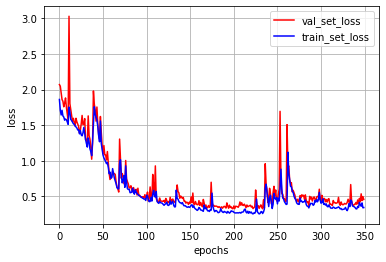

In [35]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len,y_vloss,c='red',label='val_set_loss')
plt.plot(x_len,y_loss,c='blue',label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

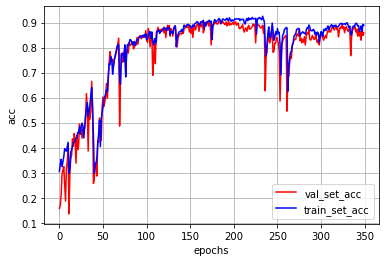

In [36]:
y_vacc = hist.history['val_acc']
y_acc = hist.history['acc']

x_len = np.arange(len(y_acc))

plt.plot(x_len,y_vacc,c='red',label='val_set_acc')
plt.plot(x_len,y_acc,c='blue',label='train_set_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()
plt.show()

In [38]:
result = tf.argmax(model.predict_on_batch(tf.expand_dims(X_test[17], 0)), axis=1)

print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), Y_test[17])
    )

Predicted result is: [7], target result is: 7


### 저장한 모델을 가져와서 테스트 데이터에 대한 예측 실행

In [3]:
demo = pd.read_csv('test_no.csv',header=None)

In [4]:
demo_np = demo.to_numpy()

In [5]:

def make_sequence_dataset2(feature):
    
    feature_list = []
    
    for i in range(len(feature)):
        
        feature_list.append(feature[i])
        
    return np.array(feature_list)
    

In [6]:
X_demo = make_sequence_dataset2(demo_np)
print(X_demo.shape)
X_demo = X_demo.reshape(360,500,1)

(360, 500)


In [7]:

print(
"Using %d samples for show"
% (len(X_demo))
)


Using 360 samples for show


In [8]:

model2 = tf.keras.models.load_model('./check.h5')

#or result[0].numpy() / result.numpy()[0]
result = tf.argmax(model2.predict_on_batch(tf.expand_dims(X_demo[28], 0)), axis=1)
print(
        "Predicted result is: %s" % (result.numpy())
    )




Predicted result is: [2]


### 예측한 값을 판다스 데이터 프레임에 저장하여 엑셀 또는 csv파일로 내보내기

In [9]:

new_data = []
new_data2 = []

for i in range (len(X_demo)):
    result = tf.argmax(model2.predict_on_batch(tf.expand_dims(X_demo[i], 0)), axis=1)
    new_data.append(result.numpy())

for i in range (len(X_demo)):
    new_data2.append(new_data[i][0])


In [10]:
real_result = pd.DataFrame(new_data2)

In [12]:
#real_result.to_csv("hey.csv")
real_result.to_excel("hey.xlsx")